In [1]:
import config_files._config_downstream as config
from models._umpire import Umpire
from models._utils import set_seed
from data.datamodules import DownstreamDataset
import pytorch_lightning as pl
import torch 
import pickle
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
set_seed(42)
pl.seed_everything(42)

clip_config = config.sweep_config
visual_config = config.visual_config
spot_config = config.spot_config
spot_config['model_name'] = 'conch'

Seed set to 42


In [3]:
# define model
model = Umpire(spot_config=spot_config,
                visual_config=visual_config,
                dim_output=clip_config['dim_output'],
                temperature=clip_config['temperature'],
                extract_layers=clip_config['extract_layers'],
                function_layers=clip_config['function_layers'],
                lr=clip_config['lr'],
                warmup=clip_config['warmup'],
                max_epochs=clip_config['max_epochs'],
                pool=clip_config['pool'],
                without_context=clip_config['without_context'],
                margin=clip_config['margin'],
                p=clip_config['p'],
                eps=clip_config['eps'])  

In [4]:
# load weights
vision_model = spot_config['model_name']
checkpoint_path = f'./weights/with_{vision_model}.pkl'
with open(checkpoint_path, "rb") as f:
    model_weights = pickle.load(f)
missing_layers = model.load_state_dict(model_weights, strict=False) 
if missing_layers.missing_keys:  
    print("\nMissing keys (layers that were not loaded):")  
    for key in missing_layers.missing_keys:  
        print(key) 
else:
    print("All layers loaded successfully")

model.cuda()
model.eval()

if vision_model == 'conch':
    from conch.open_clip_custom import create_model_from_pretrained
    vision_encoder, image_processor =  create_model_from_pretrained("conch_ViT-B-16", 
                                checkpoint_path=visual_config['pretrained_path'], 
                                force_image_size=224,
                                return_transform=True)

vision_encoder.cuda()
vision_encoder.eval()

All layers loaded successfully


CoCa(
  (text): TextTransformer(
    (token_embedding): Embedding(32007, 768)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_final): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (visual): VisualModel(
    (trunk): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kerne

In [5]:
sample_path = './downstream_tokens/151676.h5'

columns = ['images', 'tokenized_gene', 'spot_label']

dataset = DownstreamDataset(sample_path, columns, image_processor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)

In [7]:
all_spot_features = []
all_patch_features = []
all_wo_pretrain_patch_features = []
labels = []

for i, batch in tqdm(enumerate(dataloader), ncols=0, total=len(dataloader)):
    batch['tokenized_gene'] = batch['tokenized_gene'][:, :model.spot_backbone.hparams.context_length]
    batch['images'] = batch['images'].cuda()
    batch['tokenized_gene'] = batch['tokenized_gene'].cuda()

    spot_features = model.encode_gene(batch)
    patch_features = model.encode_visual(batch)

    wo_pretrain_patch_features = vision_encoder.visual.forward_no_head(batch['images'], False)

    all_spot_features.append(spot_features.detach().cpu())
    all_patch_features.append(patch_features.detach().cpu())
    all_wo_pretrain_patch_features.append(wo_pretrain_patch_features.detach().cpu())
    labels.append(batch['spot_label'])

all_spot_features = torch.cat(all_spot_features, dim=0)
all_patch_features = torch.cat(all_patch_features, dim=0)
all_wo_pretrain_patch_features = torch.cat(all_wo_pretrain_patch_features, dim=0)
labels = torch.cat(labels, dim=0)

print(all_spot_features.shape)
print(all_patch_features.shape)
print(all_wo_pretrain_patch_features.shape)
print(labels.shape)

  0% 0/215 [00:00<?, ?it/s]

100% 215/215 [01:28<00:00,  2.43it/s]

torch.Size([3430, 512])
torch.Size([3430, 512])
torch.Size([3430, 512])
torch.Size([3430])


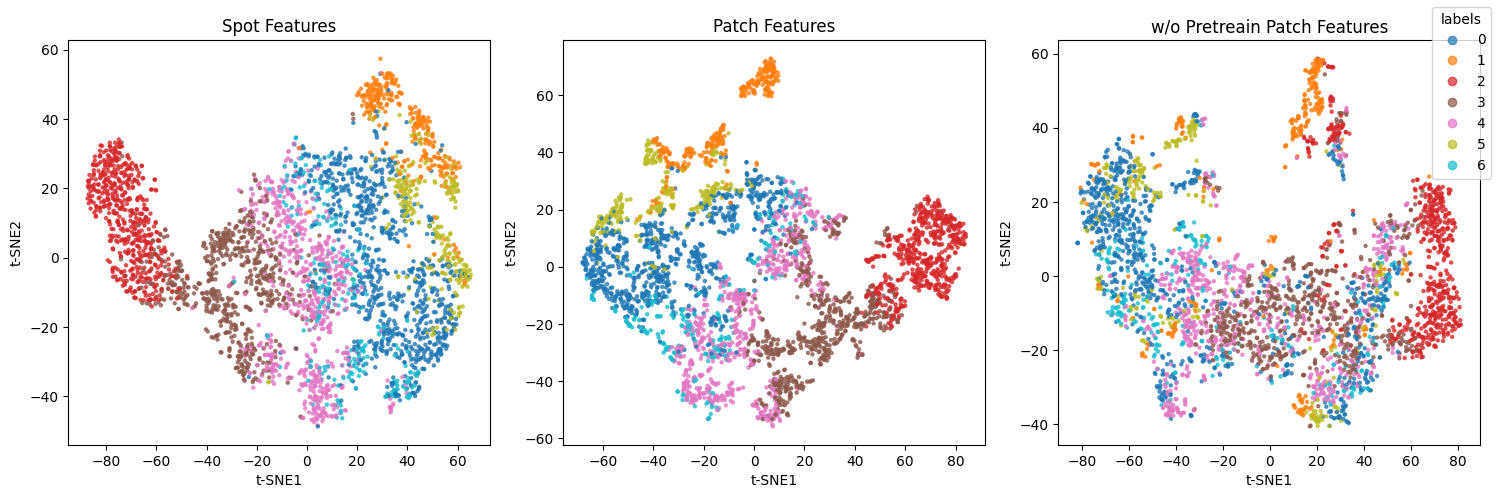

In [11]:
# 进行 t-SNE 降维
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=0)

spot_features_tsne = tsne.fit_transform(all_spot_features)
patch_features_tsne = tsne.fit_transform(all_patch_features)
wo_pretrain_patch_features_tsne = tsne.fit_transform(all_wo_pretrain_patch_features)

# 绘图
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Spot Features", "Patch Features", "w/o Pretreain Patch Features"]
tsne_results = [spot_features_tsne, patch_features_tsne, wo_pretrain_patch_features_tsne]

for ax, tsne_result, title in zip(axes.flat, tsne_results, titles):
    scatter = ax.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.7, s=5)
    ax.set_title(title)
    ax.set_xlabel("t-SNE1")
    ax.set_ylabel("t-SNE2")

# 添加颜色图例
handles, labels_unique = scatter.legend_elements(prop="colors")
fig.legend(handles, [str(i) for i in np.unique(labels.numpy())], title="labels", loc="upper right")

plt.tight_layout()
plt.show()